<a href="https://colab.research.google.com/github/ekaratnida/Automated_Tools-/blob/keep/Mini-bads3/Module3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Forecasting Using FbProphet

In [5]:
#!pip install pystan
#!pip install fbprophet
#!pip install statsmodels
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt

%matplotlib inline
# check prophet version
# print version number


       Month  Sales
0    1960-01   6550
1    1960-02   8728
2    1960-03  12026
3    1960-04  14395
4    1960-05  14587
..       ...    ...
103  1968-08  16722
104  1968-09  14385
105  1968-10  21342
106  1968-11  17180
107  1968-12  14577

[108 rows x 2 columns]


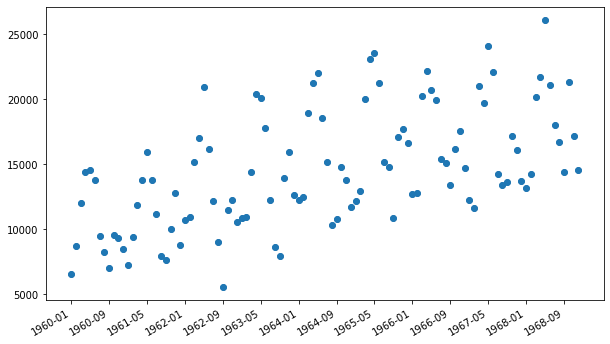

In [6]:
# load data
path = 'https://raw.githubusercontent.com/ekaratnida/Automated_Tools-/keep/Mini-bads3/monthly-car-sales.csv'
df = pd.read_csv(path)
print(df)

x = df['Month']
y = df['Sales']

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.scatter(x, y, s = 30, color = '#336699', alpha = 0.75)
ax.set_xticks(ax.get_xticks()[::8])
fig.autofmt_xdate()

plt.scatter(x,y)


In [7]:
df1 = df.copy()
df1.set_index('Month',inplace=True)
df1.index=pd.to_datetime(df1.index)
df1.dropna(inplace=True)
#Show new df after changing the index
print(df1)

            Sales
Month            
1960-01-01   6550
1960-02-01   8728
1960-03-01  12026
1960-04-01  14395
1960-05-01  14587
...           ...
1968-08-01  16722
1968-09-01  14385
1968-10-01  21342
1968-11-01  17180
1968-12-01  14577

[108 rows x 1 columns]


##Decomposition

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



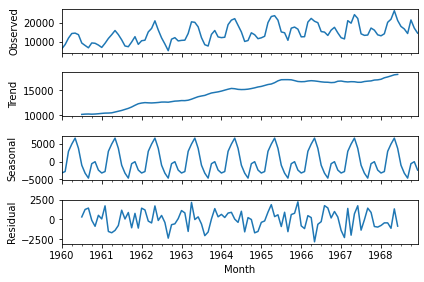

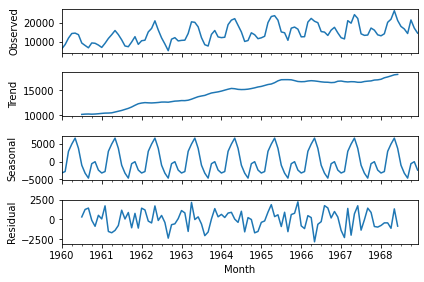

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df1['Sales'],  model='additive')
result.plot()

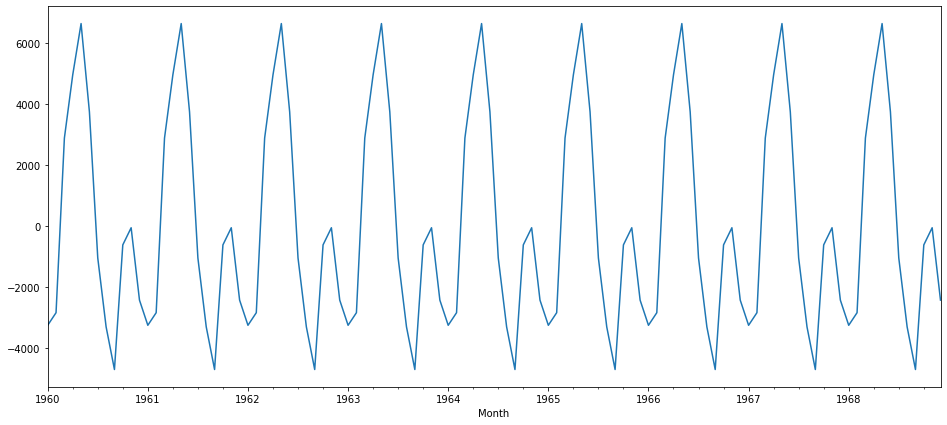

In [9]:
plt.figure(figsize = (16,7))
result.seasonal.plot();

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



1968-01-01    12086.533979
1968-02-01    12641.281138
1968-03-01    16334.386782
1968-04-01    21202.826904
1968-05-01    21153.075633
1968-06-01    23798.967294
1968-07-01    18800.922031
1968-08-01    17029.379079
1968-09-01    17657.405744
1968-10-01    17828.757305
1968-11-01    22127.063793
1968-12-01    17654.538444
Freq: MS, Name: ARIMA Predictions, dtype: float64


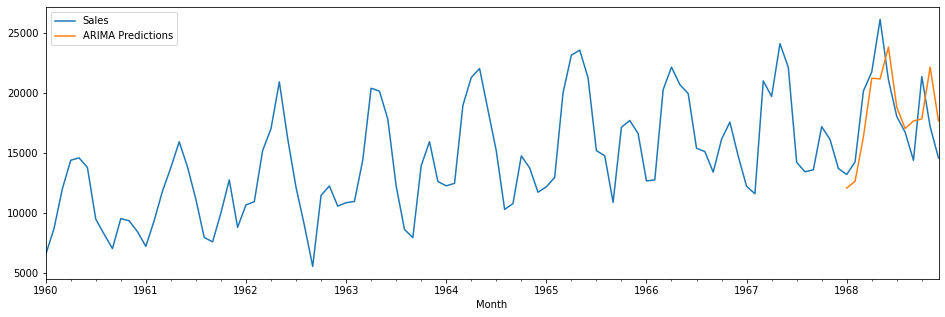

In [10]:
# arima
#from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
# Train model
arima_model = ARIMA(df1['Sales'], order=(5,1,0)) #, order = (0,1,2), seasonal_order = (4,0,3,12))
arima_result = arima_model.fit()
arima_result.summary()


#Prediction
arima_pred = arima_result.predict(start = len(df1)-12, end = len(df1)-1, typ="levels").rename("ARIMA Predictions")
print(arima_pred)

df1['Sales'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [11]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
#Model Evaluation
arima_rmse_error = rmse(df1['Sales'][-12:], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df1['Sales'][-12:].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 9010718.235051472
RMSE Error: 3001.785840970583
Mean: 18228.166666666668


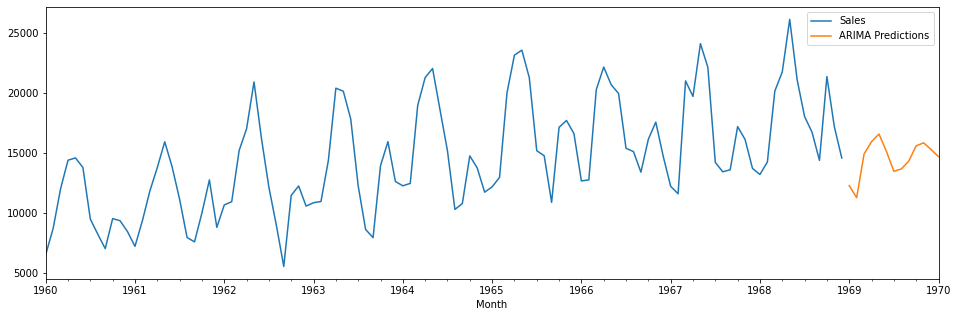

In [12]:
#Prediction
arima_pred = arima_result.predict(start = len(df1), end = len(df1)+12, typ="levels").rename("ARIMA Predictions")
arima_pred

df1['Sales'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

### **Prophet**









In [13]:
# prepare expected column names
df2 = df.copy()
df2.columns = ['ds', 'y']

# define the model
model = Prophet()

# fit model
model.fit(df2)



INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### **In sample forecast**

          ds          yhat    yhat_lower    yhat_upper
0 1968-01-01  14334.737769  12827.704356  15955.890472
1 1968-02-01  14905.955964  13320.546098  16577.299021
2 1968-03-01  20842.150502  19150.797780  22477.251800
3 1968-04-01  22870.095215  21361.761938  24461.842287
4 1968-05-01  24176.211162  22769.622255  25767.645041


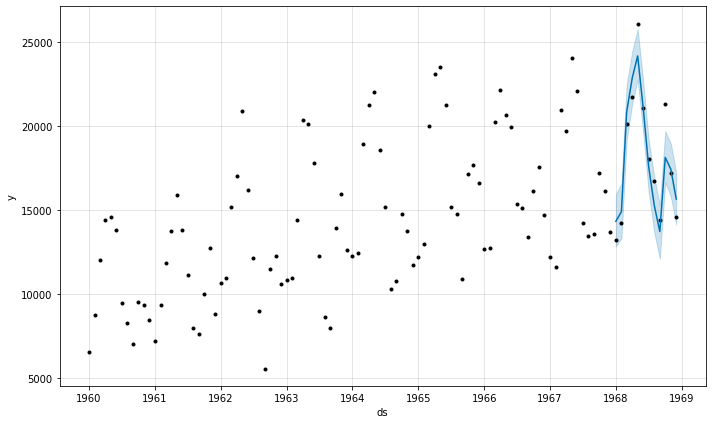

In [14]:
# define the period for which we want a prediction
future = list()
for i in range(1, 13):
	date = '1968-%02d' % i
	future.append([date])
 
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.show()



In [15]:
prophet_rmse_error = rmse(df2['y'][-12:], forecast['yhat'])
prophet_mse_error = prophet_rmse_error**2
mean_value = df2['y'][-13:-1].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

MSE Error: 1783395.1844450273
RMSE Error: 1335.4381994106006
Mean: 18156.166666666668


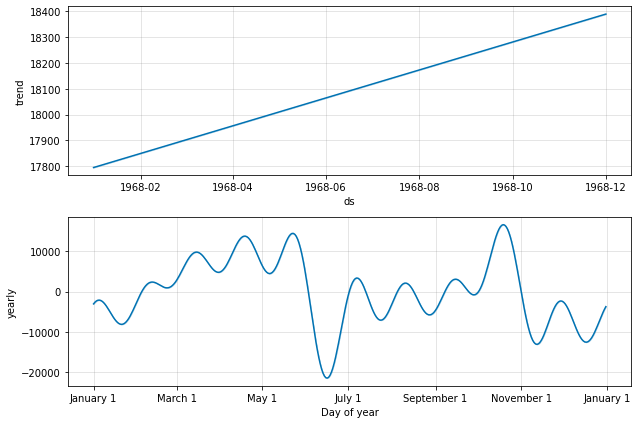

In [16]:
fig1 = model.plot_components(forecast)

### **Out of sample forecast**

          ds          yhat    yhat_lower    yhat_upper
0 1969-01-01  15375.960093  13842.153178  16999.258403
1 1969-02-01  16142.271673  14608.253558  17700.385245
2 1969-03-01  21351.832640  19840.698165  22868.821410
3 1969-04-01  23477.889811  21851.477040  25007.659129
4 1969-05-01  24988.440907  23438.458322  26583.044988


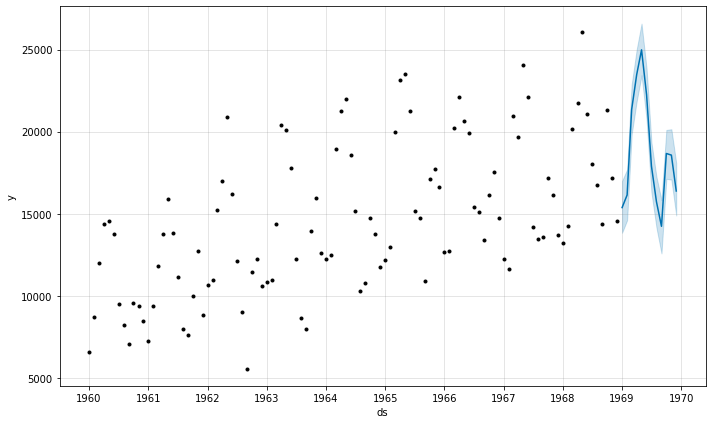

In [17]:
# define the period for which we want a prediction
future = list()
for i in range(1, 13):
	date = '1969-%02d' % i
	future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.show()

In [24]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 39.4 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


[*********************100%***********************]  1 of 1 completed


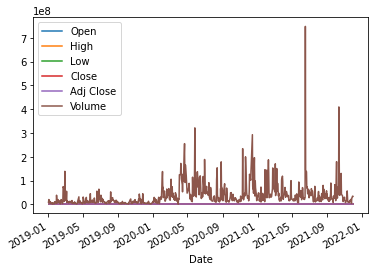

In [30]:
'''import pandas_datareader as web
import datetime
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2020, 6, 30)
df3 = web.DataReader("AAV.BK", 'yahoo', start, end)
df3.head()'''

import yfinance as yf
data = yf.download('AAV.BK', start = '2019-01-01', end='2022-01-01')
data.head()
data.plot()

#### **Evaluation**